## Steps dos 3 cases escolhidos

## Case 1 --> Explorar las ofertas relámpago, ¿qué insights puedes generar?
- 1.1) Verificando nulos
- 1.2) Verificando quantidade de valores distintos por variavel categorica
- 1.3) Verificando distribuicao de variaveis continuas
- 1.4) Correlacao entre variaveis continuas
- 2.1) Análise bivariada - Distribuicao das categoricas em relacao as variaveis continuas
- 2.1.1) Vendido vs categoricas
- 2.1.2) Quantidade Vendida vs categoricas
- 2.1.3) Vendido/Quantidade Vendida vs categoricas
- 2.1.4) Estoque vs categoricas
- 2.1.4) Estoque vs categoricas
- 2.1.4) Estoque vs categoricas
- 2.1.5) Final da oferta - Inicio da oferta

## Case 4 --> Series de tiempo Es decir, predecir las ventas de los siguientes 21 días

- 4.1) Verificando a tabela
- 4.2) Função auxiliares
- 4.3) Treinamento e avaliacao dos modelos

## Case 3 --> Similitud entre productos

- 3.1) LDA (Latent Dirichlet Allocation) modelagem de topicos 
- 3.2) Text cleaning matriz TF IDF
- 3.3) Master table
- 3.4) Calculo de similaridade de titulos


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') #tirar warnings 

item_title = pd.read_csv('../input/mercado-libre/items_titles.csv')
item_title_test = pd.read_csv('../input/mercado-libre/items_titles_test.csv')

ordenamento = pd.read_csv('../input/mercado-libre/ordenamiento.csv')
series = pd.read_csv('../input/mercado-libre/series.csv')

## 1 Explorar las ofertas relámpago, ¿qué insights puedes generar?


### Verificando base de dados

In [16]:
ofertas_relampago = pd.read_csv('../input/mercado-libre/ofertas_relampago.csv')
print('Número de linhas:',ofertas_relampago.shape[0])
print('Número de colunas:',ofertas_relampago.shape[1])
print('Colunas:',list(ofertas_relampago.columns))
ofertas_relampago.head()

Número de linhas: 48746
Número de colunas: 13
Colunas: ['OFFER_START_DATE', 'OFFER_START_DTTM', 'OFFER_FINISH_DTTM', 'OFFER_TYPE', 'INVOLVED_STOCK', 'REMAINING_STOCK_AFTER_END', 'SOLD_AMOUNT', 'SOLD_QUANTITY', 'ORIGIN', 'SHIPPING_PAYMENT_TYPE', 'DOM_DOMAIN_AGG1', 'VERTICAL', 'DOMAIN_ID']


,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES


### Definição do tipo de cada variável

In [17]:
categorical_features = ['OFFER_TYPE','ORIGIN','SHIPPING_PAYMENT_TYPE','DOM_DOMAIN_AGG1','VERTICAL']
numerical_features = ['SOLD_AMOUNT', 'SOLD_QUANTITY','INVOLVED_STOCK', 'REMAINING_STOCK_AFTER_END']
date_features = ['OFFER_START_DATE', 'OFFER_START_DTTM', 'OFFER_FINISH_DTTM']
id_features = ['DOMAIN_ID']

### 1.1 Verificando nulos

- Apenas 3 colunas com valores nulos, sendo a origem um valor predominante

In [18]:
def show_nulls(df):
    missing = pd.DataFrame({'types':df.dtypes, 'percentual_nulo': df.isna().sum()/len(df)}).\
                        sort_values(by='percentual_nulo',ascending = False)
    return missing[missing['percentual_nulo'] > 0]

show_nulls(ofertas_relampago)

,types,percentual_nulo
ORIGIN,object,0.767858
SOLD_AMOUNT,float64,0.495774
SOLD_QUANTITY,float64,0.495774


### 1.2 Verificando quantidade de valores distintos por variavel categorica

- 2 variaveis com apenas um valor (Origin e Offer type), ou seja não há valores diferentes dos setados o que pode ser uma hipotese de que a tabela é apenas um recorte de uma origem e tipo especifico oferecido
- A forma de pagamento apresenta apenas dois valores, porem um dos valores é nulo

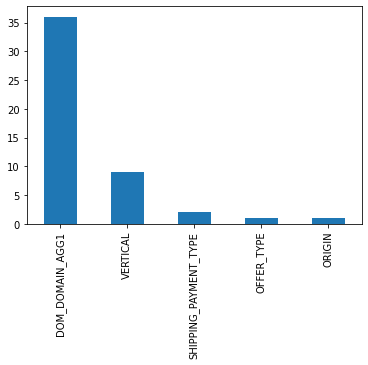

,features,distinct_values
0,DOM_DOMAIN_AGG1,36
1,VERTICAL,9
2,SHIPPING_PAYMENT_TYPE,2
3,OFFER_TYPE,1
4,ORIGIN,1


In [19]:
def categorical_features_distribution(df,cat_vars):
    df.filter(cat_vars).nunique().sort_values(ascending=False).head(50).plot(kind='bar')
    plt.show()
    list_categorical_features = df.filter(cat_vars).nunique().sort_values(ascending=False).reset_index()
    list_categorical_features.columns= ['features','distinct_values']
    return list_categorical_features

categorical_features_distribution(ofertas_relampago
                     ,cat_vars = categorical_features)

### 1.3 Verificando distribuicao de variaveis continuas

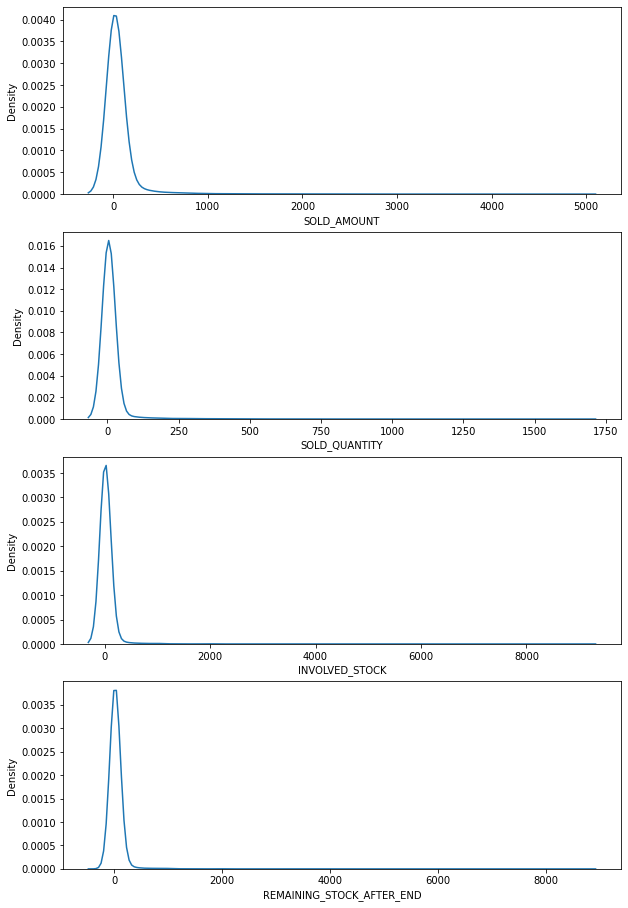

In [20]:
def plot_numerical_distribution(df):
    fig, ax = plt.subplots(4,1,figsize=(10,20))
    for i, col in enumerate(df):
        plt.subplot(5,1,i+1)
        plt.xlabel(col, fontsize=10)
        sns.kdeplot(df[col].values,bw=0.5)
    plt.show() 
    
plot_numerical_distribution(df = ofertas_relampago[numerical_features])

### 1.4 Correlacao entre variaveis continuas

- Aqui verificamos uma hipotese que a quantidade e o valor comprados são altamente correlacionados

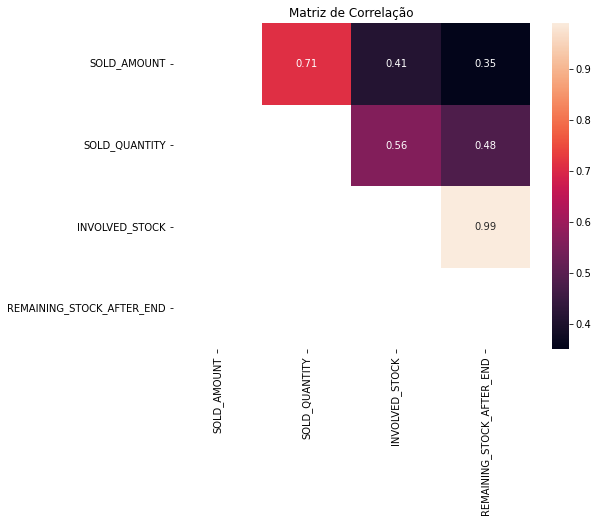

In [21]:
def triangulo_correlacao(df):
    numericas = df.copy()
    correlação = round(numericas.corr(),2)
    triangulo = correlação.where(np.triu(np.ones(correlação.shape), k=1).astype(np.bool))

    #Criando uma representação gráfica para a matriz de correlação
    sns.heatmap(triangulo, 
                xticklabels=correlação.columns.values,
                yticklabels=correlação.columns.values,annot=True)

    plt.title('Matriz de Correlação')
    plt.gcf().set_size_inches(8,6)
    plt.show()

triangulo_correlacao(ofertas_relampago[numerical_features])

### 2.1 Análise bivariada - Distribuicao das categoricas em relacao as variaveis continuas

In [42]:
def categorical_with_numerical(categorical,numerical):
    fig, ax = plt.subplots(6,1,figsize=(22,50))

    for i, col in enumerate(categorical):
        plt.subplot(5,1,i+1)
        plt.xlabel(col, fontsize=10)
        sns.boxplot(x=categorical.columns[i], y = numerical, data=categorical, showfliers=False)
        plt.xticks(rotation=90)
    plt.show() 

### 2.1.1 Vendido 

- Produto marcado como beauty healthy aparenta ter uma comportamento maior de venda em relacao aas outras categorias
- Outros produtos flutuam em torno de um intervalo menor e nao apresentam ter uma alta variancia em relacao a quantidade vendida, no entanto o produto marcado como "CE" ainda apresenta maiores oscilacoes
- produtos farmaceuticos tbm apresentam maiores medianas e variabilidade em relacao ao vendido, compara com outros produtos que flutuam em torno de um intervalo semelhante

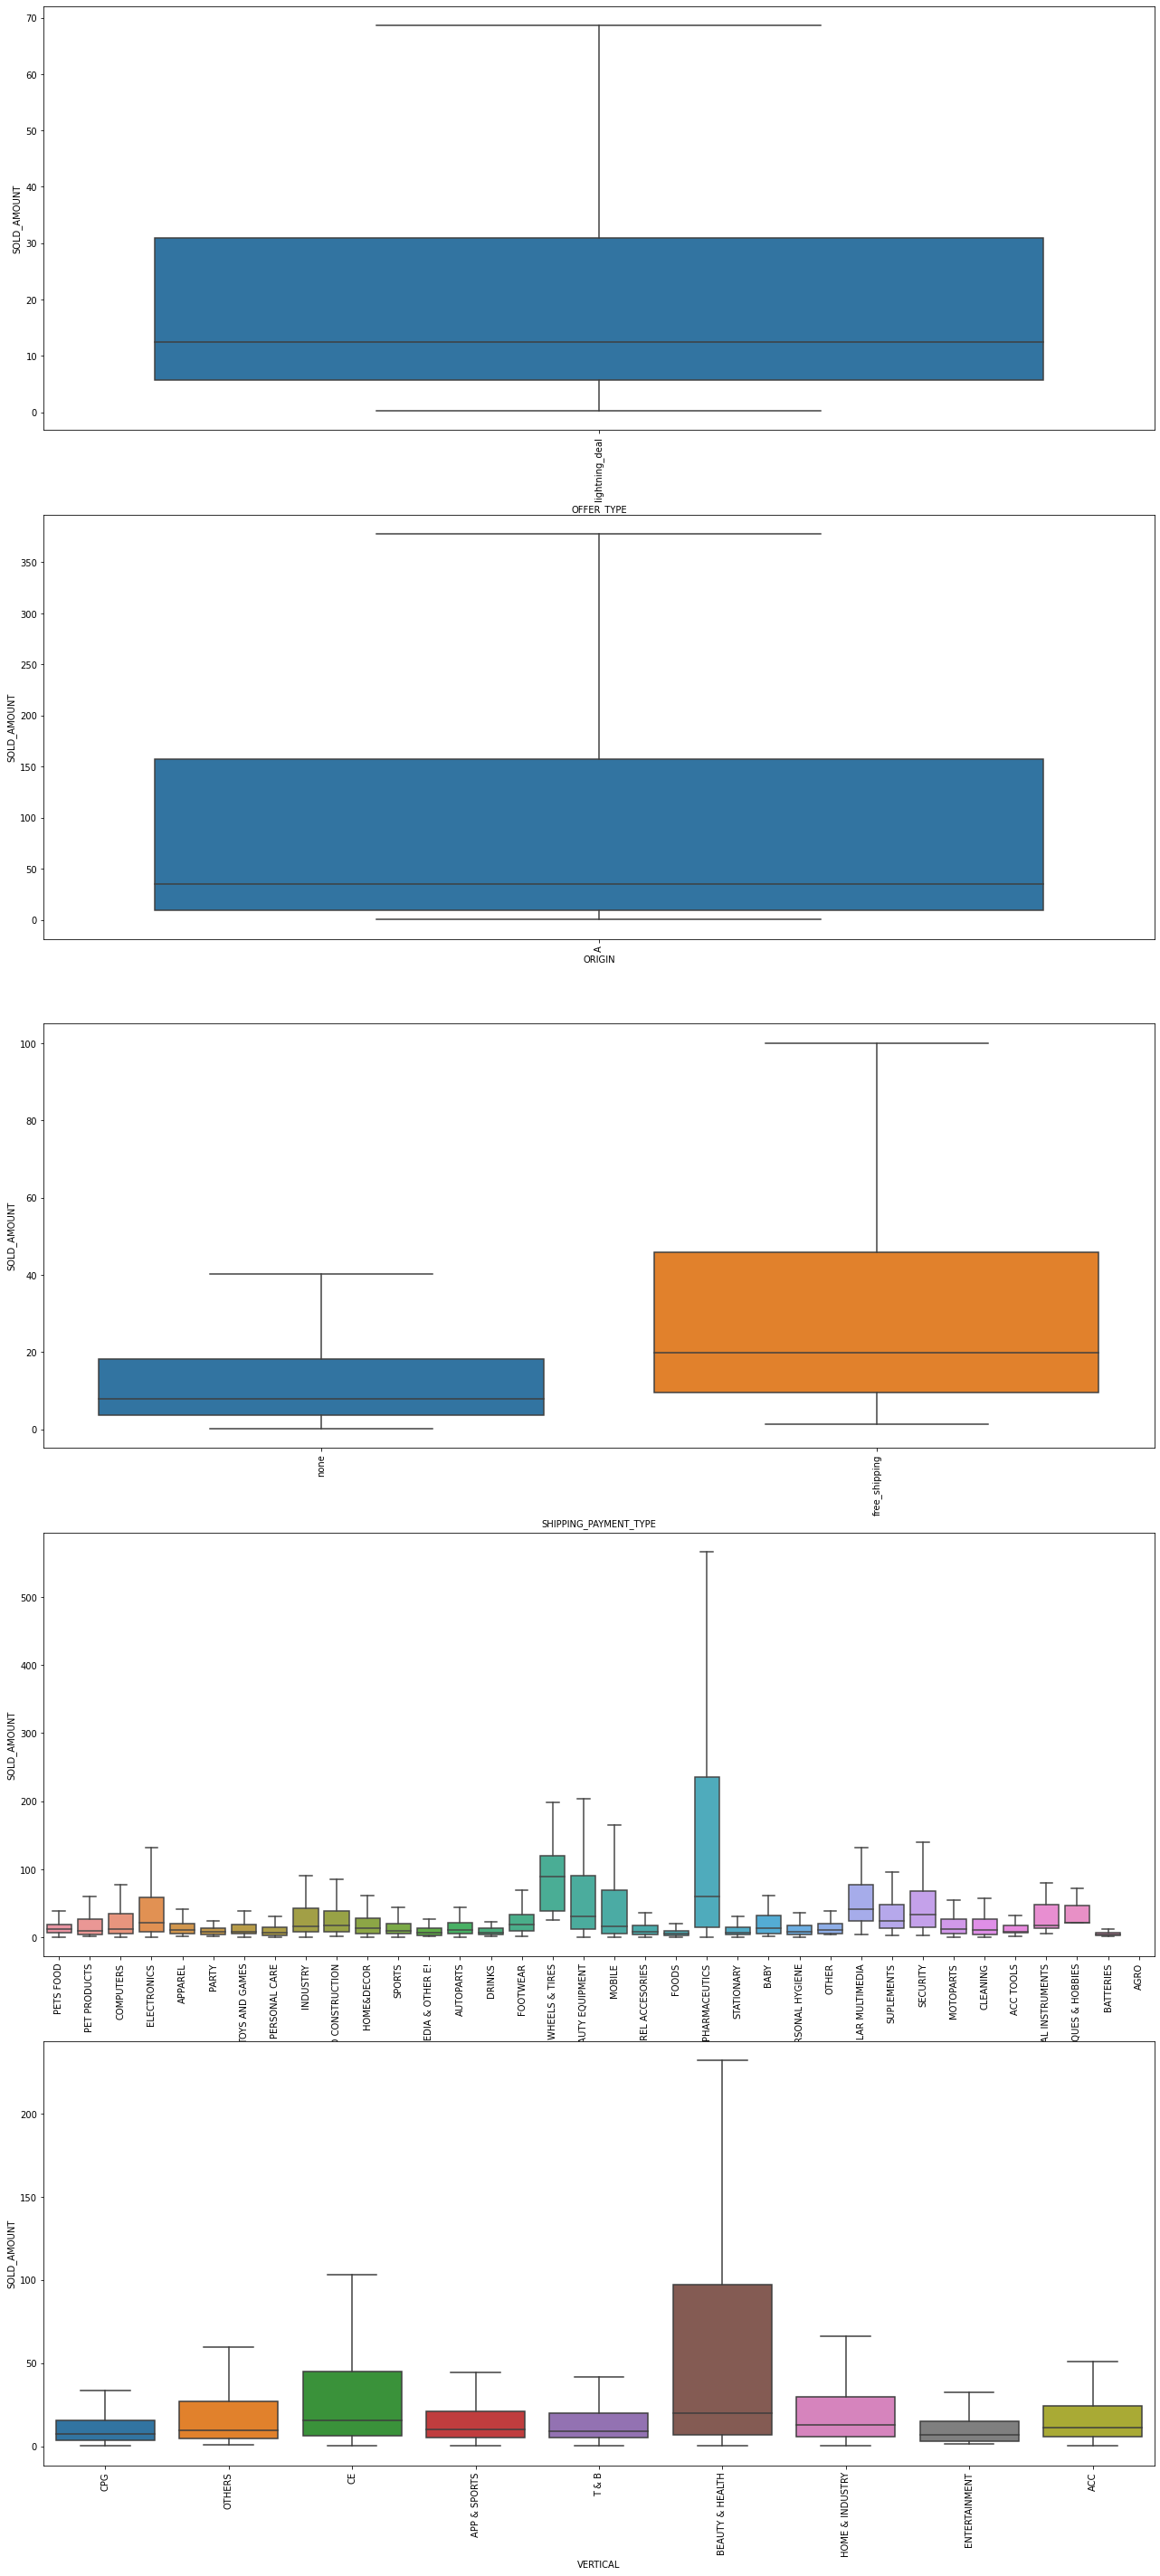

In [43]:
categorical_with_numerical(categorical = ofertas_relampago[categorical_features]
                           ,numerical = ofertas_relampago['SOLD_AMOUNT'] )

### 2.1.2 Quantidade vendida

- Aqui o comportamento observado acima se repete e isso pode ter inifluencia da variavle quantidade esta altamente correlacionada com a vendido

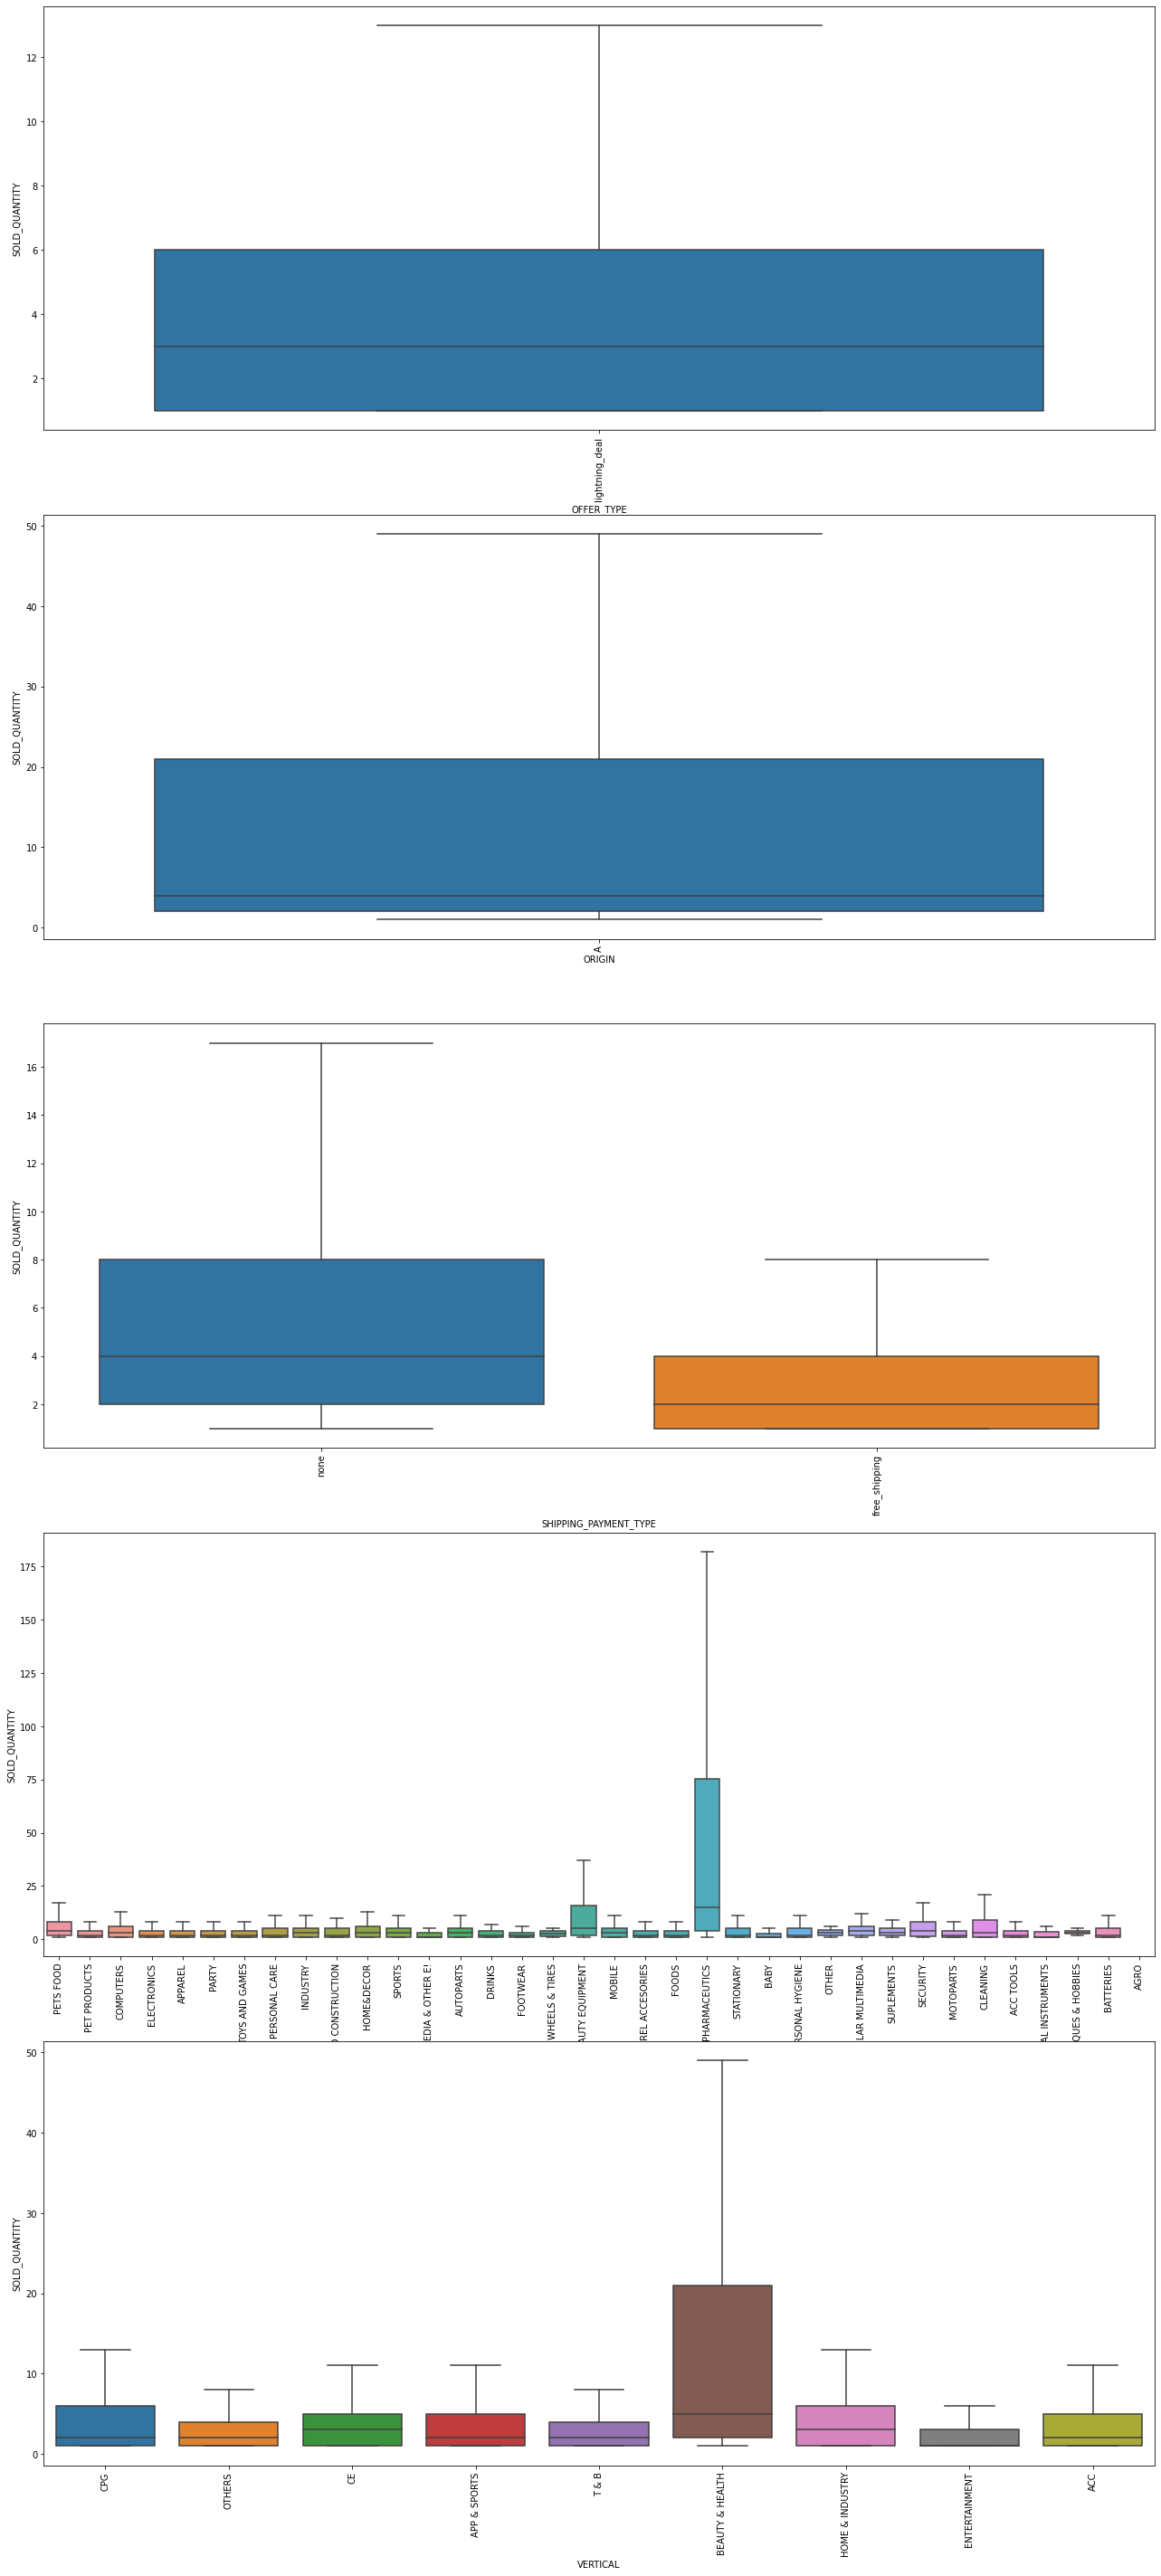

In [44]:
categorical_with_numerical(categorical = ofertas_relampago[categorical_features]
                           ,numerical = ofertas_relampago['SOLD_QUANTITY'] )

### 2.1.3 - NOVA COLUNA --> Vendido/Quantidade vendida

- Quando olhamos o vendido por quantidade vendida as distribuicoes mudam e comecamos verificar que há produtos com comportamentos diferentes de curva como "baby", "wheels and tries" e outros

In [45]:
ofertas_relampago['vendido/qtd'] = ofertas_relampago['SOLD_AMOUNT']/ofertas_relampago['SOLD_QUANTITY']

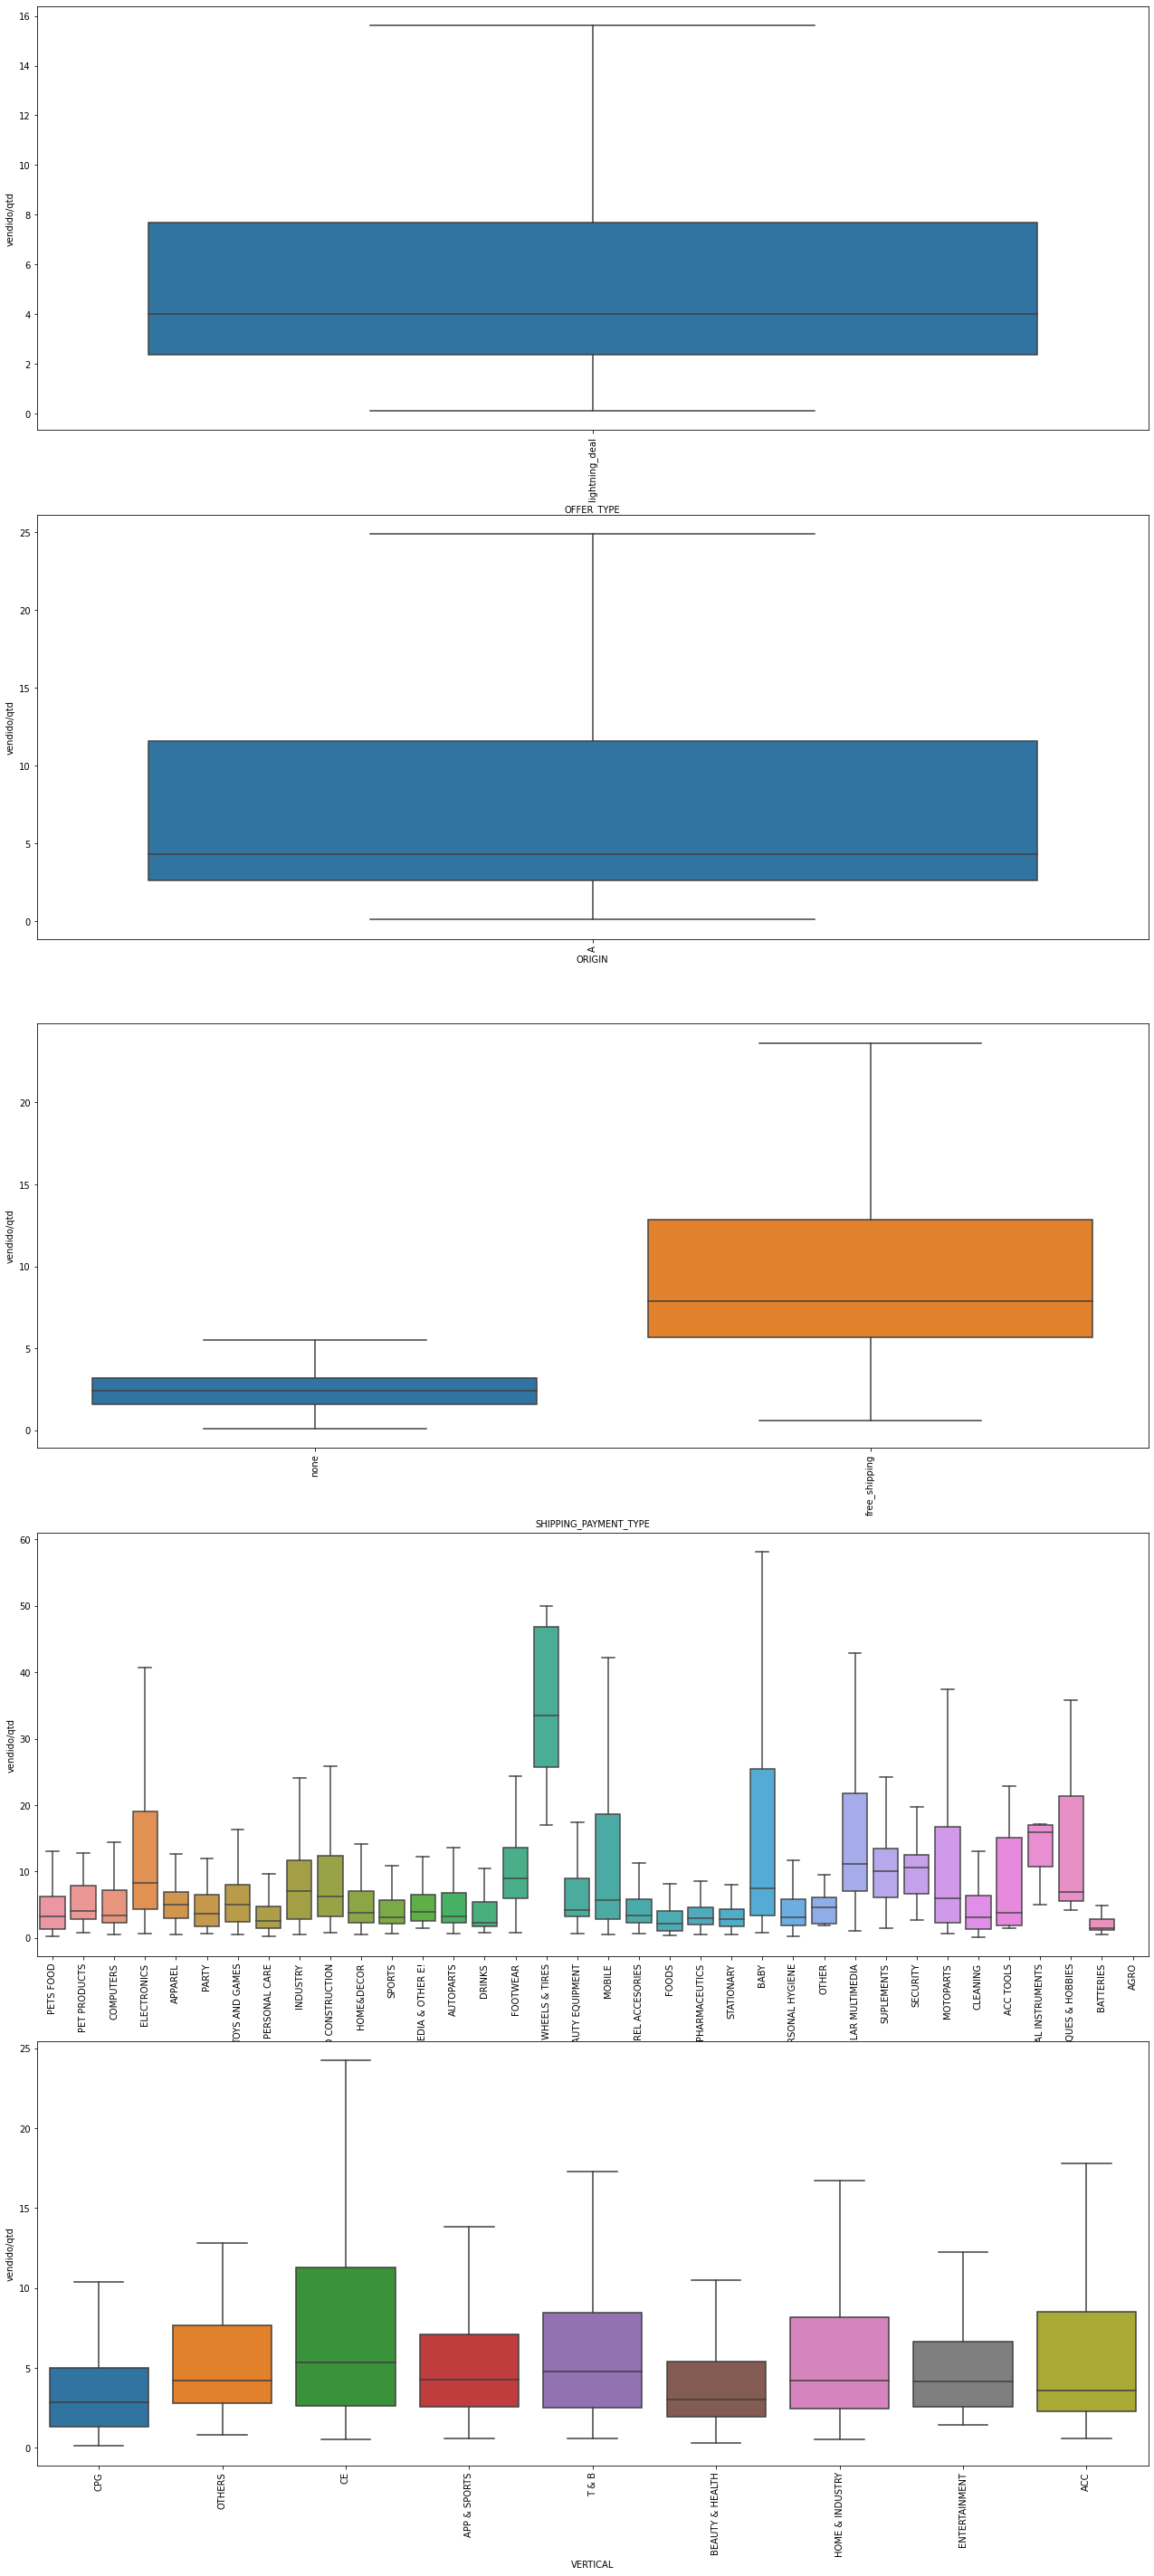

In [46]:
categorical_with_numerical(categorical = ofertas_relampago[categorical_features]
                           ,numerical = ofertas_relampago['vendido/qtd'] )

### 2.1.4 - Estoque

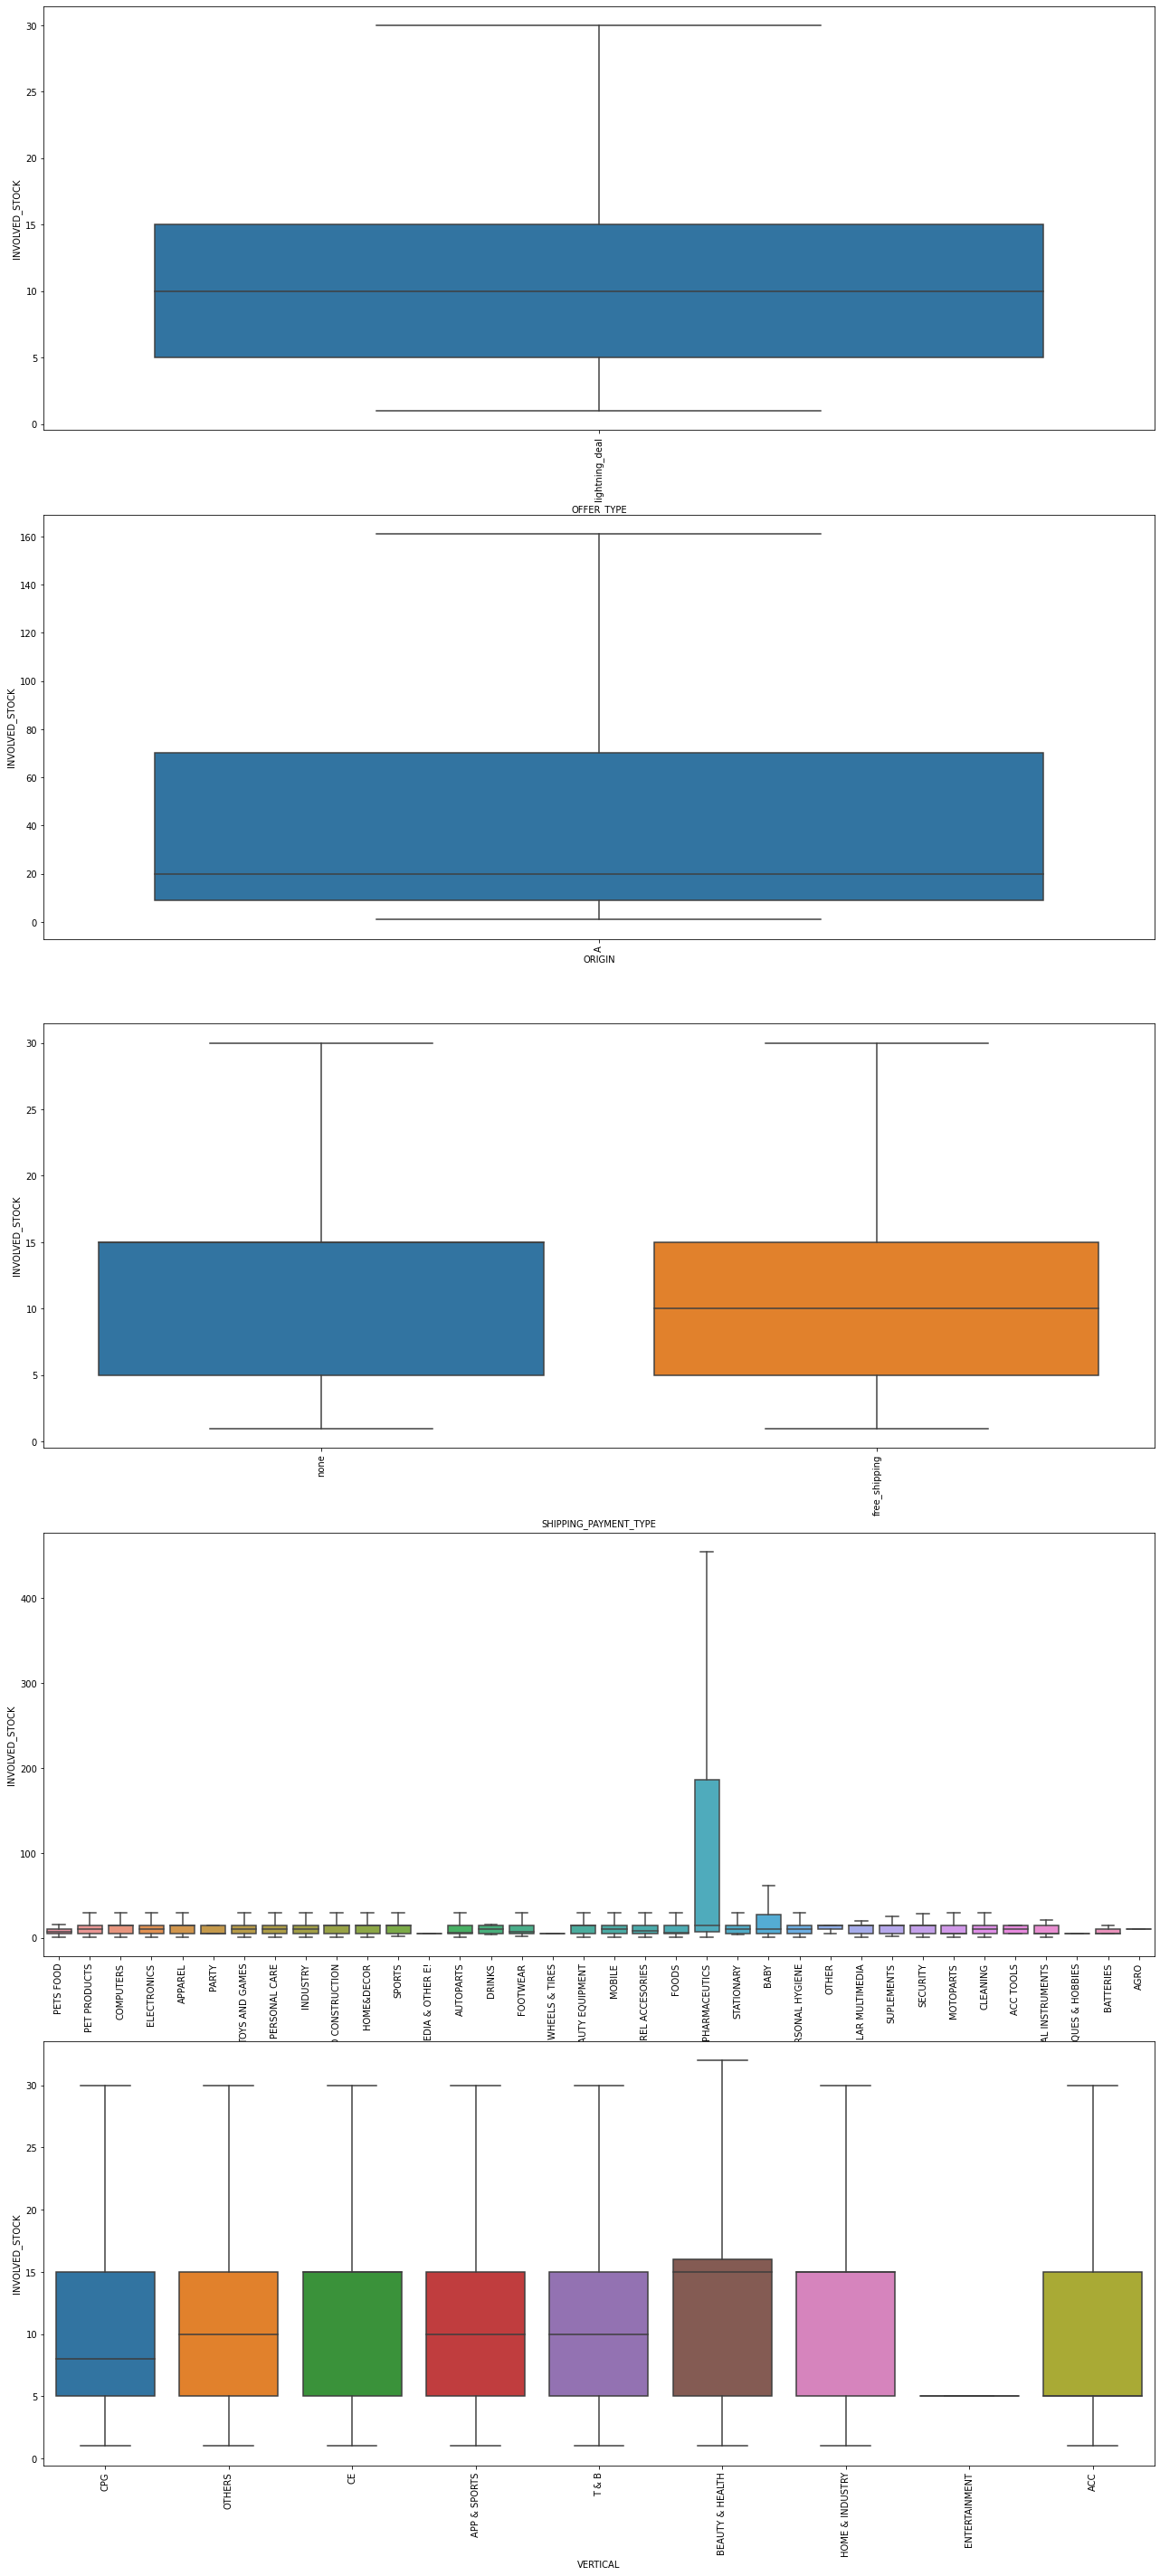

In [47]:
categorical_with_numerical(categorical = ofertas_relampago[categorical_features]
                           ,numerical = ofertas_relampago['INVOLVED_STOCK'] )

### 2.1.5 - NOVA COLUNA --> tempo de compra em horas (Final da oferta - Inicio da oferta)

- Grande parte dos produtos flutuam em torno de um mesmo intervalo, porem temos algumas categorias que possuem maior variabilidade pricipalmente relacionada a baixo valores como "wheels and tries", "instruments" e outros 

In [48]:
ofertas_relampago['OFFER_START_DTTM'] = pd.to_datetime(ofertas_relampago['OFFER_START_DTTM'])
ofertas_relampago['OFFER_FINISH_DTTM'] = pd.to_datetime(ofertas_relampago['OFFER_FINISH_DTTM'])
ofertas_relampago['DELTA_TIME'] = (ofertas_relampago['OFFER_FINISH_DTTM'] - ofertas_relampago['OFFER_START_DTTM'])
ofertas_relampago['DELTA_TIME'] = ofertas_relampago['DELTA_TIME'].apply(lambda x: x.seconds/3600)

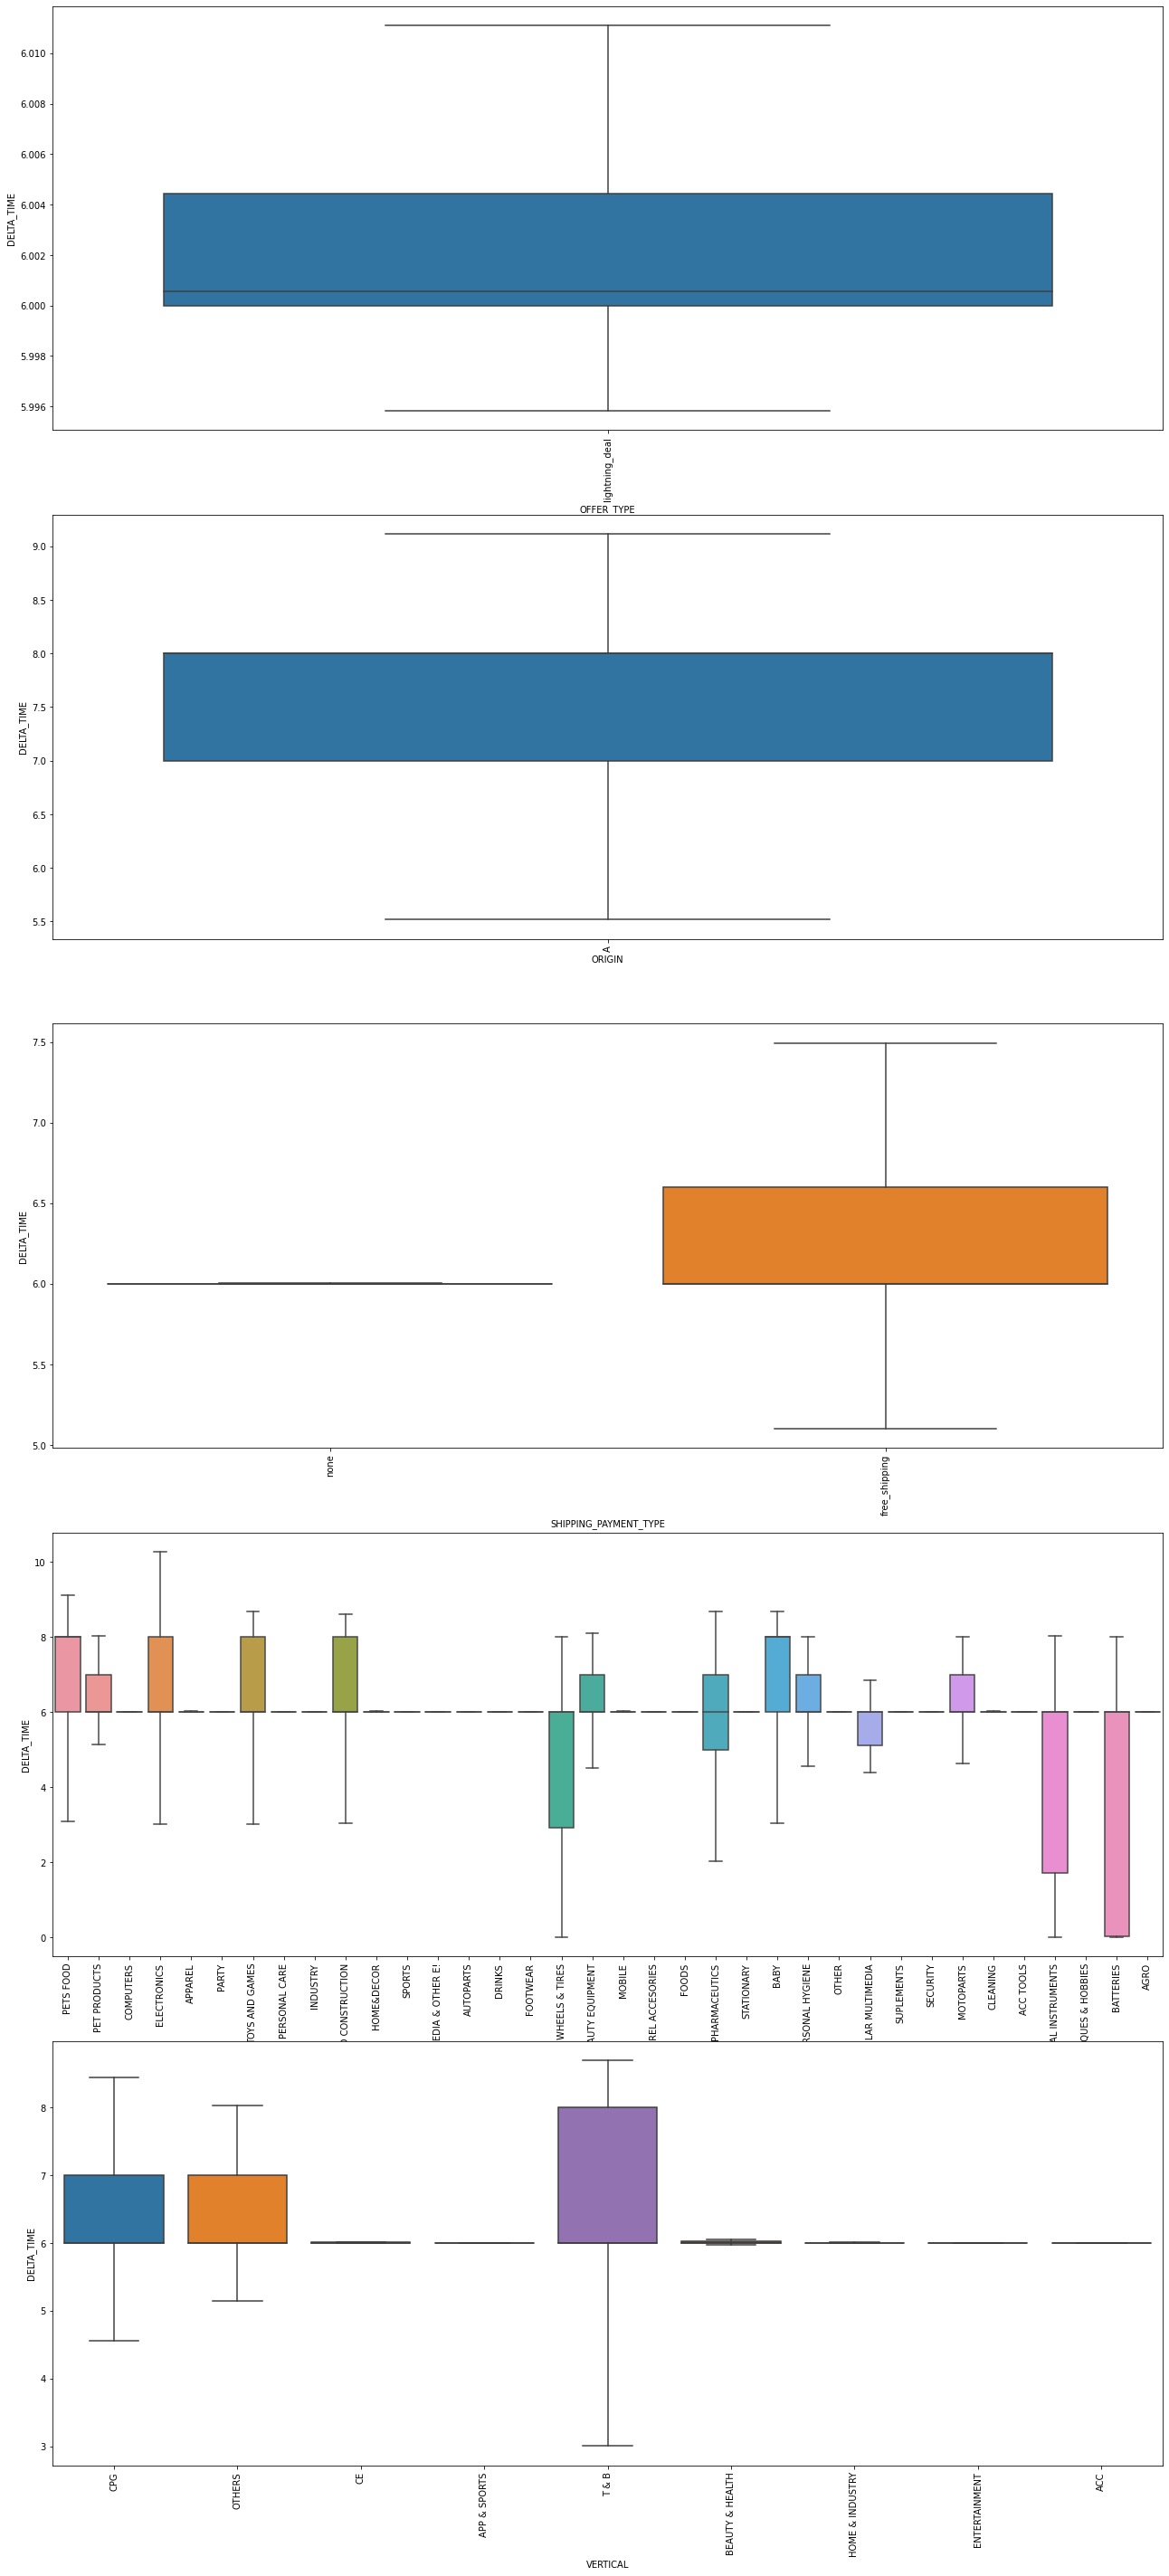

In [49]:
categorical_with_numerical(categorical = ofertas_relampago[categorical_features]
                           ,numerical = ofertas_relampago['DELTA_TIME'] )

# 4. Series de tiempo
Descripción
Pronosticar las ventas de un producto o de una categoría es un desafío recurrente
para cualquier ecommerce.
En este caso, el desafío va a ser pronosticar la cantidad de unidades diarias que van a
vender 3 categorías distintas de MELI.
El dataset “series.csv” tiene las ventas en unidades diarias de 3 categorías que
poseen un id único y su fecha de venta.


### 4.1) Verificando a tabela

In [50]:
import datetime as dt
from fbprophet import Prophet #biblioteca para craiçaõ do modelo prophet para time series
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from statsmodels.tsa.arima_model import ARIMA
#Bibliotecas para criar a função de calculo de erros:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss


df = pd.read_csv('../input/mercado-libre/series.csv')
df.head()

,CATEGORY,DATE,UNITS_SOLD
0,CATEG-1,2021-08-17,59
1,CATEG-1,2020-09-19,40
2,CATEG-2,2021-10-26,23
3,CATEG-1,2021-04-27,60
4,CATEG-2,2021-05-05,61


### 4.2) Função auxiliares

In [51]:
def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100
    
    grupo_erro = [mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

#Funcao plotar graficos com analise de erro
def plotar_erro(dados, figsize=(18,8)):
    
    # Criando a coluna do erro
    dados['Erro'] = dados.iloc[:,0] - dados.iloc[:,1]
    
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotando os valores reais e previstos
    ax1.plot(dados.iloc[:,0:2])
    ax1.legend(['Real','Prev'])
    ax1.set_title('Valores Reais vs Previstos')
    
    # Erro vs Valores previstos
    ax2.scatter(dados.iloc[:,1], dados.iloc[:,2])
    ax2.set_xlabel('Valores Previstos')
    ax2.set_ylabel('Resíduo')
    ax2.set_title('Resíduo vs Valores Previstos')
    
    ## QQ Plot do erro
    sm.graphics.qqplot(dados.iloc[:,2], line='r', ax=ax3)
    
    # Gráfico de autocorrelação do Erro
    plot_acf(dados.iloc[:,2], lags=20,zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

    
def fuller(y, lags_plots=48, figsize=(22,8)):
    
    
    #Determing rolling statistics 

    #Plot rolling statistics:    
    "Use Series como parâmetro"
    
    # Criando plots do DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize, style = '--')
    
    
    
    ax1.set_title('Série de vendas')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);#, color='teal');
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3, method='ols');
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4, )
    ax4.set_title('Distribuição das vendas ')

    plt.tight_layout()
    
    print('Resultados do teste de Dickey-Fuller:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Teste Statistico','Valor-P','Lags Usados','Números de Observações'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Valores Críticos (%s)"%key] = value.round(4)
        
    print(adftest)   


def train_forecast(df, categoria,date_col,target,dias):
    df[date_col] = pd.to_datetime(df[date_col])
    df = df[df.CATEGORY== categoria]

    treino = df[~((df[date_col].dt.year == 2021) & (df[date_col].dt.month > 6))]
    teste = df[(df[date_col].dt.year == 2021) & (df[date_col].dt.month > 6)]

    print('Training data:')
    print('----------------')
    print('%',round(len(treino)/len(df)*100,2))
    print('min training date:',treino[date_col].min())
    print('max training date:',treino[date_col].max())
    print('----------------')
    print('Test data:')
    print('----------------')
    print('%',round(len(teste)/len(df)*100,2))
    print('min test date:',teste[date_col].min())
    print('max test date:',teste[date_col].max())

    #Avalia a serie
    fuller(treino[target])

    #Prepara para o treino
    treino_fb = treino.copy()
    treino_fb.rename(columns={date_col:'ds',target:'y'},inplace=True)
    treino_fb.drop(columns='CATEGORY')
    
    #Prepara para o teste
    teste_fb = teste.copy()
    teste_fb.rename(columns={date_col:'ds',target:'y'},inplace=True)
    teste_fb.drop(columns='CATEGORY')

    #criando o modelo
    modelo = Prophet()

    #treinando o modelo
    modelo.fit(treino_fb)

    #fazendo a predicao para os proximos 21 dias
    futuro = modelo.make_future_dataframe(periods=dias)
    forecast = modelo.predict(futuro)

    #plot do gráfico com a predicao
    fig1 = modelo.plot(forecast)
    
    #observando tendencias na série
    fig2 = modelo.plot_components(forecast)
    

    fb_cv=cross_validation(modelo,initial = str(len(treino_fb)) + ' days',period='180 days', horizon='21 days')
    print(performance_metrics(fb_cv))
    plot_cross_validation_metric(fb_cv,'mape')
   

    return modelo,teste_fb

### 4.3) Treinamento e avaliacao dos modelos

- Foi treinado um modelo prophet para cada uma das 3 categorias com validação cruzada
- A escolha do algoritmo foi devido a restricao de tempo e a facilidade de treinar um mvp0, alem do algoritmo se ajustar bem a series que possuam mudanca de tendencia na sua decomposicao
- Outro ponto importante que o prophet nao assume que a serie seja estacionaria, portanto ganhariamos mais tempo em pre processing
- Para cada modelo foi avaliado o MAPE dentro dos 21 dias de previcao e como está o gráfico de autocorrelação e autocorrelação parcial da nossa variavel resposta
- o modelo é salvo no objeto model_{version}


#### Possiveis próximos passos

Poderia ser avaliado como esta a estacionaridade da serie e testados algumas outras abordagens mais tradicionais como ARIMA, alem disso poderiamos tentar suavizar a variavel resposta com algum transformacao ou até considerar feriados como variaveis dependentes para resolvermos esse tipo de problema

### Treina primeira categoria

Training data:
----------------
% 84.78
min training date: 2018-10-16 00:00:00
max training date: 2021-06-30 00:00:00
----------------
Test data:
----------------
% 15.22
min test date: 2021-07-01 00:00:00
max test date: 2021-11-12 00:00:00
Resultados do teste de Dickey-Fuller:
Teste Statistico          -16.5449
Valor-P                     0.0000
Lags Usados                 2.0000
Números de Observações    749.0000
Valores Críticos (1%)      -3.4391
Valores Críticos (5%)      -2.8654
Valores Críticos (10%)     -2.5688
dtype: float64
Initial log joint probability = -15.022
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1429.09   0.000254304       75.3301      0.4135      0.4135      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       1430.57    0.00223753        214.96   2.437e-05       0.001      194  LS failed, Hessian reset 
     199       1431.73   0.000161565   

  0%|          | 0/2 [00:00<?, ?it/s]

Initial log joint probability = -37.1462
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1104.12   0.000264936       99.9918           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       1104.15   0.000149835       92.0691   1.452e-06       0.001      187  LS failed, Hessian reset 
     148       1104.16   4.37619e-08       89.3517      0.1706           1      238   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.9229
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1378.3    0.00239874        181.62    2.38e-05       0.001      155  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1380.29   0.000166391       49.19

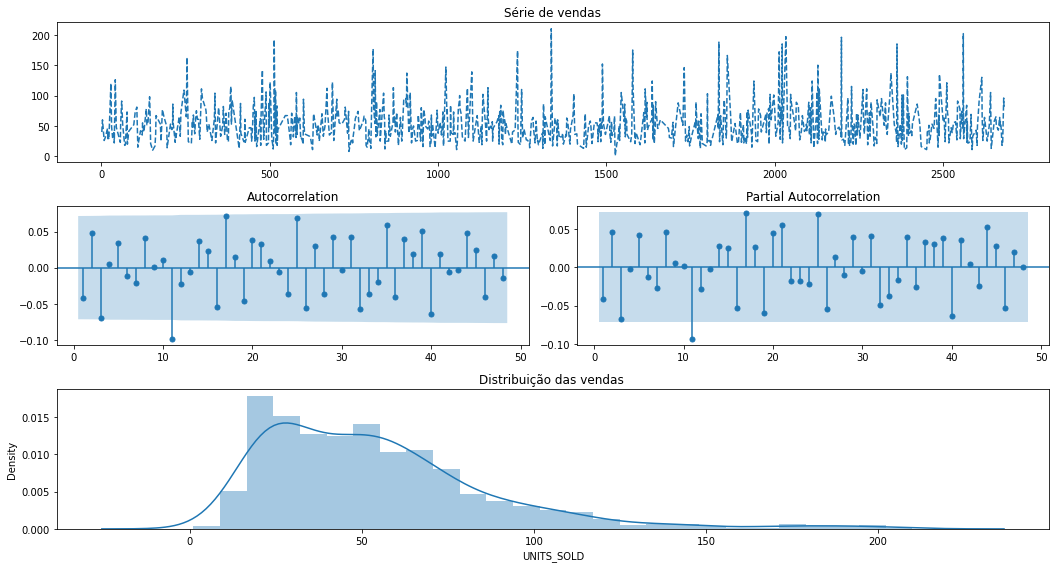

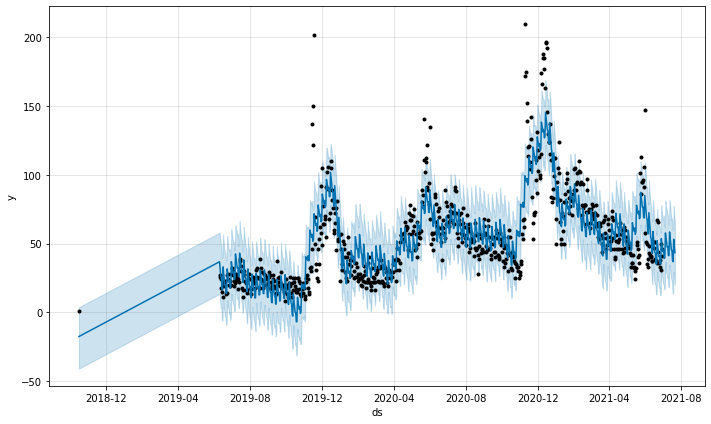

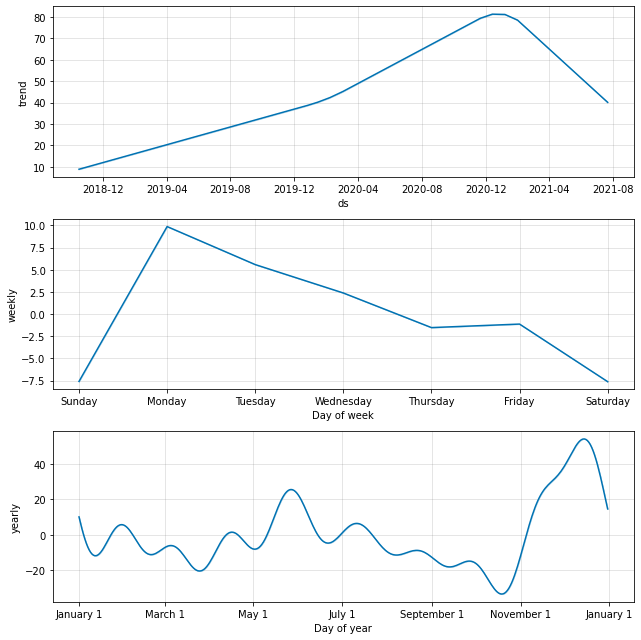

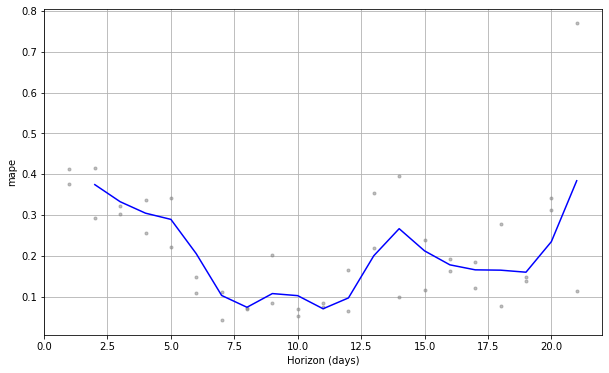

In [53]:
model_1,teste1 = train_forecast(df = pd.read_csv('../input/mercado-libre/series.csv'),
               categoria = 'CATEG-1',
               date_col= 'DATE',
               target = 'UNITS_SOLD',
               dias = 21)

### Treina segunda categoria

Training data:
----------------
% 84.64
min training date: 2018-10-16 00:00:00
max training date: 2021-06-30 00:00:00
----------------
Test data:
----------------
% 15.36
min test date: 2021-07-01 00:00:00
max test date: 2021-11-12 00:00:00
Resultados do teste de Dickey-Fuller:
Teste Statistico          -27.1290
Valor-P                     0.0000
Lags Usados                 0.0000
Números de Observações    743.0000
Valores Críticos (1%)      -3.4392
Valores Críticos (5%)      -2.8654
Valores Críticos (10%)     -2.5688
dtype: float64
Initial log joint probability = -18.9116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1398.55    0.00194011       81.4976      0.5103      0.5103      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       1401.14   0.000511979       71.4608    6.88e-06       0.001      290  LS failed, Hessian reset 
     199       1401.31   0.000589472  

  0%|          | 0/2 [00:00<?, ?it/s]

Initial log joint probability = -14.8668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1407.66   5.99243e-05       60.3761      0.1624           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       1408.73    0.00107456       146.597   1.137e-05       0.001      212  LS failed, Hessian reset 
     199       1409.13   1.51958e-05       67.6116     0.04155     0.04155      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1409.65   0.000447066       147.422   3.474e-06       0.001      461  LS failed, Hessian reset 
     299       1410.05    0.00021588       82.1046      0.9221      0.9221      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     332       1410.12   1.34669e-05       80.8778   1.682e-07       0.001      573  LS failed, Hessian rese

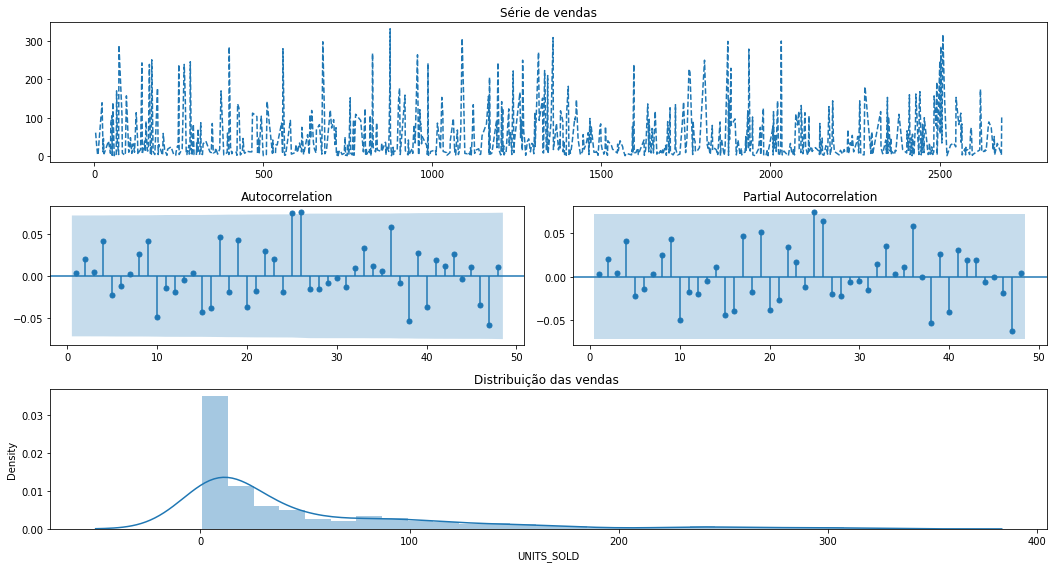

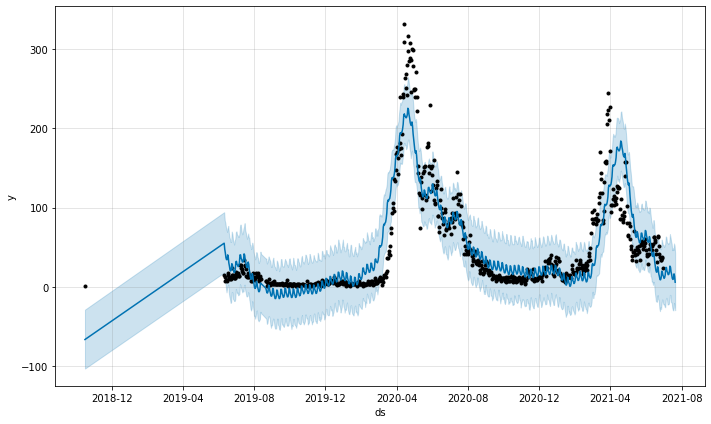

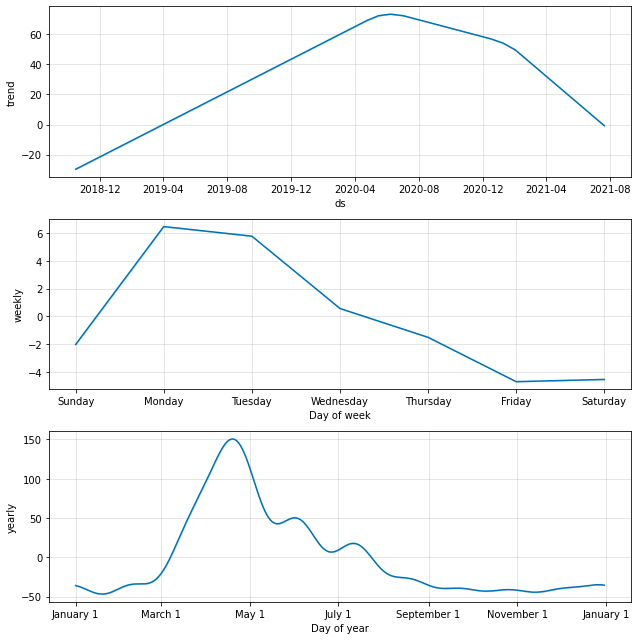

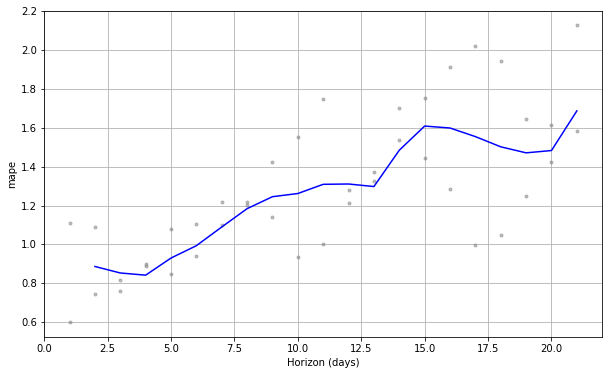

In [54]:
model_2,teste2 = train_forecast(df = pd.read_csv('../input/mercado-libre/series.csv'),
               categoria = 'CATEG-2',
               date_col= 'DATE',
               target = 'UNITS_SOLD',
               dias = 21)

In [ ]:
avaliar_teste = model2.predict(teste2)[['ds','yhat']].set_index('ds').join(teste2.set_index('ds'))
print(avaliar_teste.head())
check_erro(avaliar_teste.y,avaliar_teste.yhat)

Training data:
----------------
% 85.33
min training date: 2018-09-24 00:00:00
max training date: 2021-06-30 00:00:00
----------------
Test data:
----------------
% 14.67
min test date: 2021-07-01 00:00:00
max test date: 2021-11-12 00:00:00
Resultados do teste de Dickey-Fuller:
Teste Statistico          -19.9901
Valor-P                     0.0000
Lags Usados                 1.0000
Números de Observações    783.0000
Valores Críticos (1%)      -3.4387
Valores Críticos (5%)      -2.8652
Valores Críticos (10%)     -2.5687
dtype: float64
Initial log joint probability = -6.5764
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1715.31   0.000374469       58.0639           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       1715.63   0.000232453        60.805    4.79e-06       0.001      202  LS failed, Hessian reset 
     199       1716.52   0.000679703   

  0%|          | 0/2 [00:00<?, ?it/s]

Initial log joint probability = -21.3091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       1275.44   0.000651975       108.496   4.066e-06       0.001      152  LS failed, Hessian reset 
      99       1275.94   0.000862419       63.8784           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       1276.22   1.57287e-07       54.2284      0.6269      0.2431      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.27778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1671.48   0.000561043       98.4931       0.323       0.323      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       1673.41   0.000855483       197.272   3.324e-06       0.0

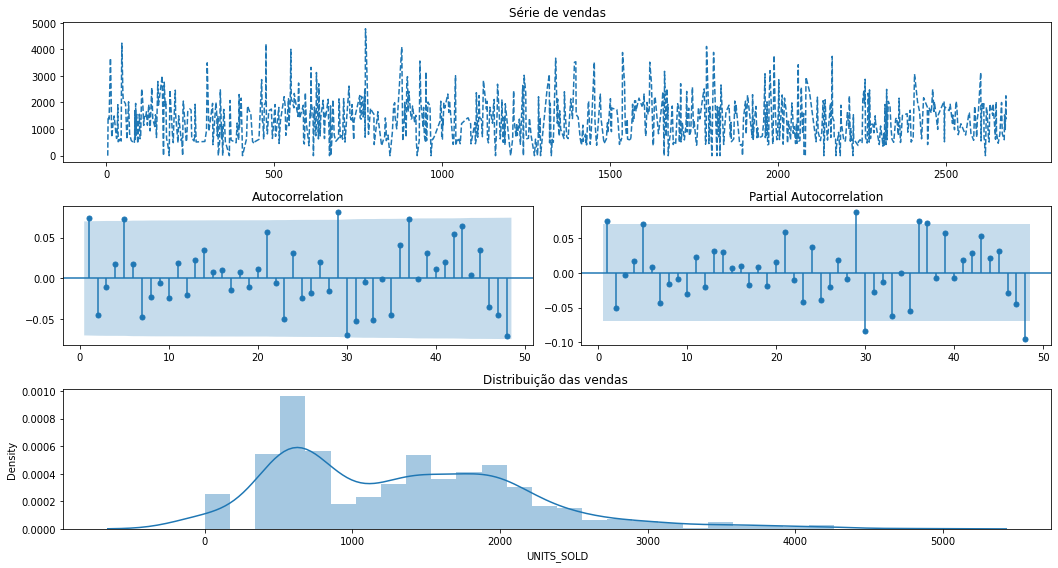

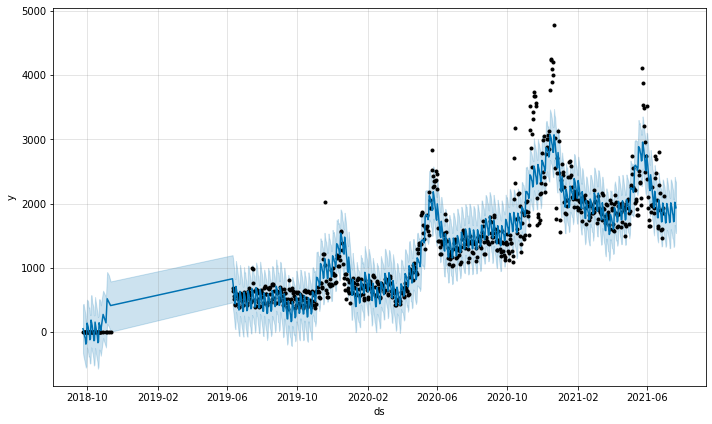

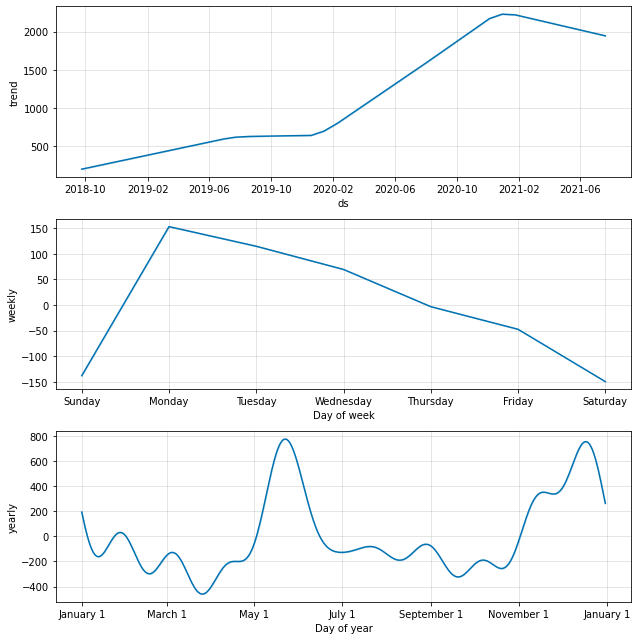

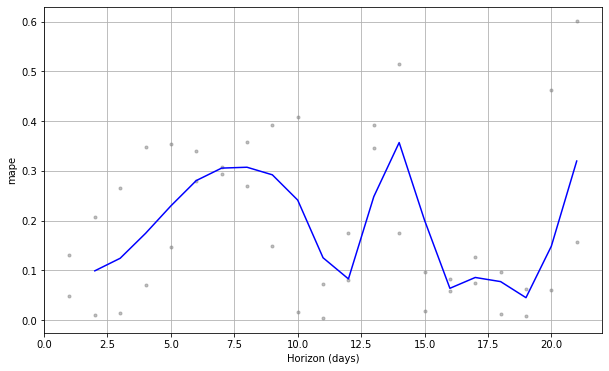

In [55]:
model_3,teste3 = train_forecast(df = pd.read_csv('../input/mercado-libre/series.csv'),
               categoria = 'CATEG-3',
               date_col= 'DATE',
               target = 'UNITS_SOLD',
               dias = 21)

In [ ]:
avaliar_teste = model3.predict(teste2)[['ds','yhat']].set_index('ds').join(teste3.set_index('ds'))
print(avaliar_teste.head())
check_erro(avaliar_teste.y,avaliar_teste.yhat)

# 3. Similitud entre productos
Descripción
Un desafío constante en MELI es el de poder agrupar productos similares utilizando
algunos atributos de estos como pueden ser el título, la descripción o su imagen.
Para este desafío tenemos un dataset “items_titles.csv” que tiene títulos de 30 mil
productos de 3 categorías diferentes de Mercado Libre Brasil

### 3.1) LDA (Latent Dirichlet Allocation) modelagem de topicos 
- usado para encontrar 3 categorias e a probabilidade de cada um dos textos pertecem a um das categorias

In [74]:
from sklearn.decomposition import LatentDirichletAllocation
from string import punctuation
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 
import re
from sklearn.metrics.pairwise import cosine_similarity

#Garantindo que os dados nao tem duplicada
item_title = item_title.drop_duplicates()

#Baixando stopwords em portgues
nltk.download('stopwords')
stopwords_portuguese = set(nltk.corpus.stopwords.words('portuguese') + list(punctuation))

#remove number
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

#Vamos usar o TF IDF irá considerar a frequencia das palavras e a proporcao que as palavras aparecem 
vectorizer = TfidfVectorizer(
                             stop_words=stopwords_portuguese,
                             min_df=500,
                            preprocessor=preprocess_text)

matrix = vectorizer.fit_transform(item_title['ITE_ITEM_TITLE'])
matrix_test = vectorizer.fit_transform(item_title_test['ITE_ITEM_TITLE'])

LDA = LatentDirichletAllocation(n_components=3,random_state=42)

#training a model
LDA.fit(matrix)

#tarnsform
topic_results = LDA.transform(matrix)

compilado_proba_topic_modeling = item_title.join(pd.DataFrame(topic_results))
compilado_proba_topic_modeling['topic'] = topic_results.argmax(axis=1)
compilado_proba_topic_modeling.index = compilado_proba_topic_modeling['ITE_ITEM_TITLE']
compilado_proba_topic_modeling = compilado_proba_topic_modeling.drop(columns = 'ITE_ITEM_TITLE')
compilado_proba_topic_modeling

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,0,1,2,topic
ITE_ITEM_TITLE,,,,
Tênis Ascension Posh Masculino - Preto E Vermelho,0.737844,0.132858,0.129298,0
Tenis Para Caminhada Super Levinho Spider Corrida,0.606281,0.123769,0.269950,0
Tênis Feminino Le Parc Hocks Black/ice Original Envio Já,0.638424,0.233916,0.127660,0
Tênis Olympikus Esportivo Academia Nova Tendência Triunfo,0.766459,0.118473,0.115068,0
Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve,0.139609,0.373038,0.487353,2
...,...,...,...,...
Tênis Vans Old Skool I Love My Vans - Usado - Feminino,0.152248,0.705943,0.141809,1
Tênis Feminino Preto Moleca 5296155,0.680052,0.192906,0.127042,0
Tenis Botinha Com Pelo Via Marte Original Lançamento,0.592817,0.125845,0.281338,0


### 3.2) Matrix do TF IDF

In [63]:
counts = pd.DataFrame(
    matrix.toarray(),
    index=item_title['ITE_ITEM_TITLE'],
    columns=vectorizer.get_feature_names())

counts.head(3)

,academia,alto,aro,azul,bicicleta,bike,branco,cadarço,caminhada,cano,...,rosa,sapatenis,sapatilha,sapatênis,slip,star,tenis,tv,tênis,usthemp
ITE_ITEM_TITLE,,,,,,,,,,,,,,,,,,,,,
Tênis Ascension Posh Masculino - Preto E Vermelho,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.352490,0.0
Tenis Para Caminhada Super Levinho Spider Corrida,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.636305,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.393552,0.0,0.000000,0.0
Tênis Feminino Le Parc Hocks Black/ice Original Envio Já,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.354462,0.0


### 3.3) Master table usada para calcular a similaridade entre dois textos
TF IDF + merge com modelagem de topicos

In [66]:
master_table = compilado_proba_topic_modeling.join(counts)
master_table.head()

,0,1,2,topic,academia,alto,aro,azul,bicicleta,bike,...,rosa,sapatenis,sapatilha,sapatênis,slip,star,tenis,tv,tênis,usthemp
ITE_ITEM_TITLE,,,,,,,,,,,,,,,,,,,,,
Tênis Ascension Posh Masculino - Preto E Vermelho,0.737844,0.132858,0.129298,0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.352490,0.0
Tenis Para Caminhada Super Levinho Spider Corrida,0.606281,0.123769,0.269950,0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.393552,0.0,0.000000,0.0
Tênis Feminino Le Parc Hocks Black/ice Original Envio Já,0.638424,0.233916,0.127660,0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.354462,0.0
Tênis Olympikus Esportivo Academia Nova Tendência Triunfo,0.766459,0.118473,0.115068,0,0.566448,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.204886,0.0
Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve,0.139609,0.373038,0.487353,2,0.000000,0.0,0.0,0.0,0.830191,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


### Criar tabela em teste para escoragem

In [75]:
matrix = vectorizer.fit_transform(item_title_test['ITE_ITEM_TITLE'])

counts = pd.DataFrame(
    matrix.toarray(),
    index=item_title_test['ITE_ITEM_TITLE'],
    columns=vectorizer.get_feature_names())

counts = counts.astype(np.float32)
similarities = cosine_similarity(counts)

In [79]:
def score_by_num_title(i,similarities):
    df = pd.DataFrame(columns= ['ITE_ITEM_TITLE',0,'ITE_ITEM_TITLE2'])
    base = pd.DataFrame(similarities[i],index=counts.index).reset_index()
    base['ITE_ITEM_TITLE2'] = counts.index[i]
    df = pd.concat([df,base]).drop_duplicates()
    df.columns = ['ITE_ITEM_TITLE','score','ITE_ITEM_TITLE2']
    return df

### - 3.4) Calculo de similaridade de titulos

In [80]:
score_by_num_title(0,similarities)

,ITE_ITEM_TITLE,score,ITE_ITEM_TITLE2
0,Tênis Olympikus Esporte Valente - Masculino Kids,1.000000,Tênis Olympikus Esporte Valente - Masculino Kids
1,Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C...,0.000000,Tênis Olympikus Esporte Valente - Masculino Kids
2,Tênis Usthemp Slip-on Temático - Labrador 2,0.502236,Tênis Olympikus Esporte Valente - Masculino Kids
3,Tênis Casual Feminino Moleca Tecido Tie Dye,0.186918,Tênis Olympikus Esporte Valente - Masculino Kids
4,Tênis Star Baby Sapatinho Conforto + Brinde,0.502236,Tênis Olympikus Esporte Valente - Masculino Kids
...,...,...,...
9995,Chuteira Futsal Oxn Velox 3 Infantil,0.000000,Tênis Olympikus Esporte Valente - Masculino Kids
9996,Sapatenis Casual Masculino Estiloso 24horas Co...,0.566282,Tênis Olympikus Esporte Valente - Masculino Kids
9997,Tênis Feminino Infantil Molekinha Tie Dye,0.184688,Tênis Olympikus Esporte Valente - Masculino Kids
9998,Tênis Feminino Leve Barato Ganhe 1 Colchonete ...,0.277678,Tênis Olympikus Esporte Valente - Masculino Kids
